# Inference plot of 3 regions

In [1]:
# Import libraries
import numpy as np
import math
import branchpro
import scipy.stats
import matplotlib
import plotly.graph_objects as go
from matplotlib import pyplot as plt
import os
import pandas as pd
import datetime

In [2]:
# Read serial interval
si_file = 'si-epinow'
path = os.path.join('../data_library/serial_interval', '{}.csv'.format(si_file))
serial_interval = pd.read_csv(path, header=None)
serial_interval = serial_interval.fillna(0)
serial_intervals = serial_interval.values.T

## Ontario data

In [3]:
# Read Ontario data
path = os.path.join('../data_library/covid_ontario/ON.csv')
data = pd.read_csv(path)[:51]

In [4]:
time_key = 'Time'
num_timepoints = max(data[time_key])
data_times = data[time_key]

# Pad with zeros the time points where we have no information on
# the number of incidences
padded_inc_data = data.set_index(time_key).reindex(
    range(
        1, max(data_times)+1)
        ).fillna(0).reset_index()
locally_infected_cases_ON = padded_inc_data['Incidence Number']
imported_cases_ON = padded_inc_data['Imported Cases']

start_times = np.arange(1, num_timepoints+1, dtype=int)
times = np.arange(num_timepoints+1)

In [5]:
tau = 6
R_t_start = tau+1
a = 1
b = 0.2

# Run inferences for different values of epsilon
column_names = ['Time Points', 'Mean', 'Lower bound CI', 'Upper bound CI', 'Central Probability', 'Epsilon']
epsilon_range = [0.25, 1, 2]
chosen_times = [10, 15, 20, 25, 30, 40]

all_intervals = pd.DataFrame(columns=column_names)
all_intervals_chosen = pd.DataFrame(columns=column_names)
# Transform our incidence data into pandas dataframes
inc_data = pd.DataFrame(
    {
        'Time': start_times,
        'Incidence Number': locally_infected_cases_ON
    }
)

imported_inc_data = pd.DataFrame(
    {
        'Time': start_times,
        'Incidence Number': imported_cases_ON
    }
)

for epsilon in epsilon_range:
    inference = branchpro.LocImpBranchProPosteriorMultSI(
        inc_data=inc_data,
        imported_inc_data=imported_inc_data,
        epsilon=epsilon,
        daily_serial_intervals=serial_intervals,
        alpha=a,
        beta=b)

    inference.run_inference(tau=tau)
    intervals = inference.get_intervals(central_prob=0)
    intervals = intervals.append(inference.get_intervals(central_prob=.25))
    intervals = intervals.append(inference.get_intervals(central_prob=.95))
    temp = inference.get_intervals(central_prob=.95)

    intervals['Epsilon'] = [epsilon] * len(intervals.index)

    intervals_chosen = pd.DataFrame(columns=intervals.columns)
    for time_pt in chosen_times:
        intervals_chosen = intervals_chosen.append(
            intervals.loc[intervals['Time Points']== time_pt])

    all_intervals = all_intervals.append(intervals)
    all_intervals_chosen = all_intervals_chosen.append(intervals_chosen)

In [6]:
inference_times = sorted(list(set(all_intervals['Time Points'].tolist())))
all_intervals_ON = all_intervals[all_intervals['Central Probability']==0.95]

In [7]:
large_all_intervals = pd.DataFrame(columns=column_names)
large_all_intervals_chosen = pd.DataFrame(columns=column_names)
last_time_r_more_than_1_ON = []
last_time_r_more_than_1_LowerCI_ON = []
last_time_r_more_than_1_UpperCI_ON = []

last_time_r_less_than_1_ON = []
last_time_r_less_than_1_LowerCI_ON = []
last_time_r_less_than_1_UpperCI_ON = []

proportion_time_r_more_than_1_ON = []
proportion_time_r_more_than_1_LowerCI_ON = []
proportion_time_r_more_than_1_UpperCI_ON = []

large_epsilon_range = np.arange(0.1, 2.5, 0.1)

for epsilon in large_epsilon_range:
    inference = branchpro.LocImpBranchProPosteriorMultSI(
        inc_data=inc_data,
        imported_inc_data=imported_inc_data,
        epsilon=epsilon,
        daily_serial_intervals=serial_intervals,
        alpha=a,
        beta=b)

    inference.run_inference(tau=tau)

    # Last time R > 1
    mean, lower, upper = inference.last_time_r_threshold('more')
    last_time_r_more_than_1_ON.append(mean)
    last_time_r_more_than_1_LowerCI_ON.append(lower)
    last_time_r_more_than_1_UpperCI_ON.append(upper)

    # Last time R < 1
    mean, lower, upper = inference.last_time_r_threshold('less')
    last_time_r_less_than_1_ON.append(mean)
    last_time_r_less_than_1_LowerCI_ON.append(lower)
    last_time_r_less_than_1_UpperCI_ON.append(upper)

    # Proportion time R > 1
    mean, lower, upper = inference.proportion_time_r_more_than_1(.95)
    proportion_time_r_more_than_1_ON.append(mean)
    proportion_time_r_more_than_1_LowerCI_ON.append(lower)
    proportion_time_r_more_than_1_UpperCI_ON.append(upper)

## New South Wales data

In [8]:
# Read New South Wales data
path = os.path.join('../data_library/covid_australia/NSW.csv')
data = pd.read_csv(path)[:51]

time_key = 'Time'
num_timepoints = max(data[time_key])
data_times = data[time_key]

# Pad with zeros the time points where we have no information on
# the number of incidences
padded_inc_data = data.set_index(time_key).reindex(
    range(
        1, max(data_times)+1)
        ).fillna(0).reset_index()
locally_infected_cases_NSW = padded_inc_data['Incidence Number']
imported_cases_NSW = padded_inc_data['Imported Cases']

start_times = np.arange(1, num_timepoints+1, dtype=int)
times = np.arange(num_timepoints+1)

In [9]:
# Run inferences for different values of epsilon
column_names = ['Time Points', 'Mean', 'Lower bound CI', 'Upper bound CI', 'Central Probability', 'Epsilon']
epsilon_range = [0.25, 1, 2]
chosen_times = [10, 15, 20, 25, 30, 40]

all_intervals = pd.DataFrame(columns=column_names)
all_intervals_chosen = pd.DataFrame(columns=column_names)
# Transform our incidence data into pandas dataframes
inc_data = pd.DataFrame(
    {
        'Time': start_times,
        'Incidence Number': locally_infected_cases_NSW
    }
)

imported_inc_data = pd.DataFrame(
    {
        'Time': start_times,
        'Incidence Number': imported_cases_NSW
    }
)

for epsilon in epsilon_range:
    inference = branchpro.LocImpBranchProPosteriorMultSI(
        inc_data=inc_data,
        imported_inc_data=imported_inc_data,
        epsilon=epsilon,
        daily_serial_intervals=serial_intervals,
        alpha=a,
        beta=b)

    inference.run_inference(tau=tau)
    intervals = inference.get_intervals(central_prob=0)
    intervals = intervals.append(inference.get_intervals(central_prob=.25))
    intervals = intervals.append(inference.get_intervals(central_prob=.95))
    temp = inference.get_intervals(central_prob=.95)

    intervals['Epsilon'] = [epsilon] * len(intervals.index)

    intervals_chosen = pd.DataFrame(columns=intervals.columns)
    for time_pt in chosen_times:
        intervals_chosen = intervals_chosen.append(
            intervals.loc[intervals['Time Points']== time_pt])

    all_intervals = all_intervals.append(intervals)
    all_intervals_chosen = all_intervals_chosen.append(intervals_chosen)

In [10]:
inference_times = sorted(list(set(all_intervals['Time Points'].tolist())))
all_intervals_NSW = all_intervals[all_intervals['Central Probability']==0.95]

In [11]:
large_all_intervals = pd.DataFrame(columns=column_names)
large_all_intervals_chosen = pd.DataFrame(columns=column_names)
last_time_r_more_than_1_NSW = []
last_time_r_more_than_1_LowerCI_NSW = []
last_time_r_more_than_1_UpperCI_NSW = []

last_time_r_less_than_1_NSW = []
last_time_r_less_than_1_LowerCI_NSW = []
last_time_r_less_than_1_UpperCI_NSW = []

proportion_time_r_more_than_1_NSW = []
proportion_time_r_more_than_1_LowerCI_NSW = []
proportion_time_r_more_than_1_UpperCI_NSW = []

large_epsilon_range = np.arange(0.1, 2.5, 0.1)

for epsilon in large_epsilon_range:
    inference = branchpro.LocImpBranchProPosteriorMultSI(
        inc_data=inc_data,
        imported_inc_data=imported_inc_data,
        epsilon=epsilon,
        daily_serial_intervals=serial_intervals,
        alpha=a,
        beta=b)

    inference.run_inference(tau=tau)
    # Last time R > 1
    mean, lower, upper = inference.last_time_r_threshold('more')
    last_time_r_more_than_1_NSW.append(mean)
    last_time_r_more_than_1_LowerCI_NSW.append(lower)
    last_time_r_more_than_1_UpperCI_NSW.append(upper)

    # Last time R < 1
    mean, lower, upper = inference.last_time_r_threshold('less')
    last_time_r_less_than_1_NSW.append(mean)
    last_time_r_less_than_1_LowerCI_NSW.append(lower)
    last_time_r_less_than_1_UpperCI_NSW.append(upper)

    # Proportion time R > 1
    mean, lower, upper = inference.proportion_time_r_more_than_1(.95)
    proportion_time_r_more_than_1_NSW.append(mean)
    proportion_time_r_more_than_1_LowerCI_NSW.append(lower)
    proportion_time_r_more_than_1_UpperCI_NSW.append(upper)

## Victoria data

In [12]:
# Read Victoria data
path = os.path.join('../data_library/covid_australia/VIC.csv')
data = pd.read_csv(path)[:51]

time_key = 'Time'
num_timepoints = max(data[time_key])
data_times = data[time_key]

# Pad with zeros the time points where we have no information on
# the number of incidences
padded_inc_data = data.set_index(time_key).reindex(
    range(
        1, max(data_times)+1)
        ).fillna(0).reset_index()
locally_infected_cases_VIC = padded_inc_data['Incidence Number']
imported_cases_VIC = padded_inc_data['Imported Cases']

start_times = np.arange(1, num_timepoints+1, dtype=int)
times = np.arange(num_timepoints+1)

# Run inferences for different values of epsilon
column_names = ['Time Points', 'Mean', 'Lower bound CI', 'Upper bound CI', 'Central Probability', 'Epsilon']
epsilon_range = [0.25, 1, 2]
chosen_times = [10, 15, 20, 25, 30, 40]

all_intervals = pd.DataFrame(columns=column_names)
all_intervals_chosen = pd.DataFrame(columns=column_names)
# Transform our incidence data into pandas dataframes
inc_data = pd.DataFrame(
    {
        'Time': start_times,
        'Incidence Number': locally_infected_cases_VIC
    }
)

imported_inc_data = pd.DataFrame(
    {
        'Time': start_times,
        'Incidence Number': imported_cases_VIC
    }
)

for epsilon in epsilon_range:
    inference = branchpro.LocImpBranchProPosteriorMultSI(
        inc_data=inc_data,
        imported_inc_data=imported_inc_data,
        epsilon=epsilon,
        daily_serial_intervals=serial_intervals,
        alpha=a,
        beta=b)

    inference.run_inference(tau=tau)
    intervals = inference.get_intervals(central_prob=0)
    intervals = intervals.append(inference.get_intervals(central_prob=.25))
    intervals = intervals.append(inference.get_intervals(central_prob=.95))
    temp = inference.get_intervals(central_prob=.95)

    intervals['Epsilon'] = [epsilon] * len(intervals.index)

    intervals_chosen = pd.DataFrame(columns=intervals.columns)
    for time_pt in chosen_times:
        intervals_chosen = intervals_chosen.append(
            intervals.loc[intervals['Time Points']== time_pt])

    all_intervals = all_intervals.append(intervals)
    all_intervals_chosen = all_intervals_chosen.append(intervals_chosen)
    
prior_dist = scipy.stats.gamma(a, scale=1/b)

inference_times = sorted(list(set(all_intervals['Time Points'].tolist())))
epsilon_range = [0.25, 1, 2]
all_intervals_VIC = all_intervals[all_intervals['Central Probability']==0.95]

In [13]:
large_all_intervals = pd.DataFrame(columns=column_names)
large_all_intervals_chosen = pd.DataFrame(columns=column_names)
last_time_r_more_than_1_VIC = []
last_time_r_more_than_1_LowerCI_VIC = []
last_time_r_more_than_1_UpperCI_VIC = []

last_time_r_less_than_1_VIC = []
last_time_r_less_than_1_LowerCI_VIC = []
last_time_r_less_than_1_UpperCI_VIC = []

proportion_time_r_more_than_1_VIC = []
proportion_time_r_more_than_1_LowerCI_VIC = []
proportion_time_r_more_than_1_UpperCI_VIC = []

large_epsilon_range = np.arange(0.1, 2.5, 0.1)

for epsilon in large_epsilon_range:
    inference = branchpro.LocImpBranchProPosteriorMultSI(
        inc_data=inc_data,
        imported_inc_data=imported_inc_data,
        epsilon=epsilon,
        daily_serial_intervals=serial_intervals,
        alpha=a,
        beta=b)

    inference.run_inference(tau=tau)
    # Last time R > 1
    mean, lower, upper = inference.last_time_r_threshold('more')
    last_time_r_more_than_1_VIC.append(mean)
    last_time_r_more_than_1_LowerCI_VIC.append(lower)
    last_time_r_more_than_1_UpperCI_VIC.append(upper)

    # Last time R < 1
    mean, lower, upper = inference.last_time_r_threshold('less')
    last_time_r_less_than_1_VIC.append(mean)
    last_time_r_less_than_1_LowerCI_VIC.append(lower)
    last_time_r_less_than_1_UpperCI_VIC.append(upper)

    # Proportion time R > 1
    mean, lower, upper = inference.proportion_time_r_more_than_1(.95)
    proportion_time_r_more_than_1_VIC.append(mean)
    proportion_time_r_more_than_1_LowerCI_VIC.append(lower)
    proportion_time_r_more_than_1_UpperCI_VIC.append(upper)

## Combine inference plots

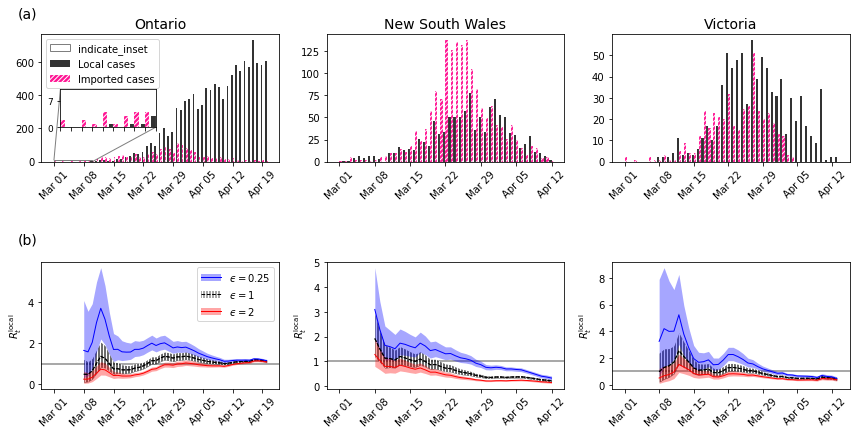

In [14]:
fig = branchpro.figures.plot_regions_inference(
    datetime.datetime(2020, 3, 1),
    ['Ontario', 'New South Wales', 'Victoria'],
    [locally_infected_cases_ON, locally_infected_cases_NSW, locally_infected_cases_VIC],
    [imported_cases_ON, imported_cases_NSW, imported_cases_VIC],
    datetime.datetime(2020, 3, 1) + datetime.timedelta(days=inference_times[0]-1),
    list(epsilon_range),
    [[all_intervals_ON.loc[all_intervals_ON['Epsilon']==eps] for eps in epsilon_range],
    [all_intervals_NSW.loc[all_intervals_NSW['Epsilon']==eps] for eps in epsilon_range],
    [all_intervals_VIC.loc[all_intervals_VIC['Epsilon']==eps] for eps in epsilon_range]],
    default_epsilon=1,
    inset_region=['Ontario'],
    show=False)

plt.savefig('combined_inference.pdf')

## Plot of Last times to R>1 and R<1 and Proprtion of time R>1

In [15]:
from plotly.subplots import make_subplots

colours = ['grey', 'orange', 'green']
regions = ['Ontario', 'New South Wales', 'Victoria']
trace_name = ['Last time R<sub>t</sub><sup>local</sup><1', 'Last time R<sub>t</sub><sup>local</sup>>1', 'Proportion of time R<sub>t</sub><sup>local</sup>>1']

titles = ['{}'.format(r) for r in regions]
titles.extend([None]*6)

traces_mean = [
    [last_time_r_less_than_1_ON, last_time_r_less_than_1_NSW, last_time_r_less_than_1_VIC],
    [last_time_r_more_than_1_ON, last_time_r_more_than_1_NSW, last_time_r_more_than_1_VIC],
    [proportion_time_r_more_than_1_ON, proportion_time_r_more_than_1_NSW, proportion_time_r_more_than_1_VIC]]

traces_lower = [
    [last_time_r_less_than_1_LowerCI_ON, last_time_r_less_than_1_LowerCI_NSW, last_time_r_less_than_1_LowerCI_VIC],
    [last_time_r_more_than_1_LowerCI_ON, last_time_r_more_than_1_LowerCI_NSW, last_time_r_more_than_1_LowerCI_VIC],
    [proportion_time_r_more_than_1_LowerCI_ON, proportion_time_r_more_than_1_LowerCI_NSW, proportion_time_r_more_than_1_LowerCI_VIC]]

traces_upper = [
    [last_time_r_less_than_1_UpperCI_ON, last_time_r_less_than_1_UpperCI_NSW, last_time_r_less_than_1_UpperCI_VIC],
    [last_time_r_more_than_1_UpperCI_ON, last_time_r_more_than_1_UpperCI_NSW, last_time_r_more_than_1_UpperCI_VIC],
    [proportion_time_r_more_than_1_UpperCI_ON, proportion_time_r_more_than_1_UpperCI_NSW, proportion_time_r_more_than_1_UpperCI_VIC]]

fig = go.Figure()
fig = make_subplots(rows=3, cols=3, subplot_titles=tuple(titles), shared_yaxes=True)

# Plot (bar chart cases each day)
for row in range(3):
    for col in range(3):
        if (row != 0) or (col != 0):
            # Plot of incidences
            fig.add_trace(
                go.Scatter(
                    x=large_epsilon_range,
                    y=traces_mean[row][col],
                    mode='lines',
                    name='Mean',
                    showlegend=False,
                    line_color=colours[0],
                ),
                row= row+1,
                col= col+1
            )

            fig.add_trace(
                go.Scatter(
                    x=large_epsilon_range,
                    y=traces_lower[row][col],
                    mode='lines',
                    name='2.5<sup>th</sup> percentile',
                    showlegend=False,
                    line_color=colours[1],
                    line={'dash': 'dot'}
                ),
                row= row+1,
                col= col+1
            )

            fig.add_trace(
                go.Scatter(
                    x=large_epsilon_range,
                    y=traces_upper[row][col],
                    mode='lines',
                    name='97.5<sup>th</sup> percentile',
                    showlegend=False,
                    line_color=colours[2],
                    line={'dash': 'dot'}
                ),
                row= row+1,
                col= col+1
            )

            fig.update_xaxes(row=row+1, col=col+1, title_text='ϵ')
        
        else:
            fig.add_trace(
                go.Scatter(
                    x=large_epsilon_range,
                    y=traces_mean[row][col],
                    mode='lines',
                    name='Mean',
                    line_color=colours[0]
                ),
                row= row+1,
                col= col+1
            )

            fig.add_trace(
                go.Scatter(
                    x=large_epsilon_range,
                    y=traces_lower[row][col],
                    mode='lines',
                    name='2.5<sup>th</sup> percentile',
                    line_color=colours[1],
                    line={'dash': 'dot'}
                ),
                row= row+1,
                col= col+1
            )

            fig.add_trace(
                go.Scatter(
                    x=large_epsilon_range,
                    y=traces_upper[row][col],
                    mode='lines',
                    name='97.5<sup>th</sup> percentile',
                    line_color=colours[2],
                    line={'dash': 'dot'}
                ),
                row= row+1,
                col= col+1
            )

            fig.update_xaxes(row=row+1, col=col+1, title_text='ϵ')


# Add axis labels
fig.update_layout(
    width=700, 
    height=800,
    plot_bgcolor='white',
    xaxis=dict(linecolor='black'),
    yaxis=dict(
        linecolor='black',
        range=[0, 62],
        tickvals=np.arange(1, 62, 10).tolist(),
        ticktext=['Mar 01', 'Mar 11', 'Mar 21', 'Mar 31', 'Apr 09', 'Apr 19', 'Apr 29']),
    xaxis2=dict(linecolor='black'),
    yaxis2=dict(
        linecolor='black',
        range=[0, 62],
        tickvals=np.arange(1, 62, 10).tolist(),
        ticktext=['Mar 01', 'Mar 11', 'Mar 21', 'Mar 31', 'Apr 09', 'Apr 19', 'Apr 29']),
    xaxis3=dict(linecolor='black'),
    yaxis3=dict(
        linecolor='black',
        range=[0, 62],
        tickvals=np.arange(1, 62, 10).tolist(),
        ticktext=['Mar 01', 'Mar 11', 'Mar 21', 'Mar 31', 'Apr 09', 'Apr 19', 'Apr 29']),
    xaxis4=dict(linecolor='black'),
    yaxis4=dict(
        linecolor='black',
        range=[0, 62],
        tickvals=np.arange(1, 62, 10).tolist(),
        ticktext=['Mar 01', 'Mar 11', 'Mar 21', 'Mar 31', 'Apr 09', 'Apr 19', 'Apr 29']),
    xaxis5=dict(linecolor='black'),
    yaxis5=dict(
        linecolor='black',
        range=[0, 62],
        tickvals=np.arange(1, 62, 10).tolist(),
        ticktext=['Mar 01', 'Mar 11', 'Mar 21', 'Mar 31', 'Apr 09', 'Apr 19', 'Apr 29']),
    xaxis6=dict(linecolor='black'),
    yaxis6=dict(
        linecolor='black',
        range=[0, 62],
        tickvals=np.arange(1, 62, 10).tolist(),
        ticktext=['Mar 01', 'Mar 11', 'Mar 21', 'Mar 31', 'Apr 09', 'Apr 19', 'Apr 29']),
    xaxis7=dict(linecolor='black'),
    yaxis7=dict(
        linecolor='black',
        range=[0, 1.2],
        tickvals=np.arange(0, 1.1, 0.2).tolist(),
        ticktext=['0', '0.2', '0.4', '0.6', '0.8', '1']),
    xaxis8=dict(linecolor='black'),
    yaxis8=dict(
        linecolor='black',
        range=[0, 1.2],
        tickvals=np.arange(0, 1.1, 0.2).tolist(),
        ticktext=['0', '0.2', '0.4', '0.6', '0.8', '1']),
    xaxis9=dict(linecolor='black'),
    yaxis9=dict(
        linecolor='black',
        range=[0, 1.2],
        tickvals=np.arange(0, 1.1, 0.2).tolist(),
        ticktext=['0', '0.2', '0.4', '0.6', '0.8', '1']),
    legend=dict(
        orientation='h',
        yanchor="bottom",
        y=1.075,
        xanchor="right",
        x=1)
    )

fig.update_yaxes(row=1, col=1, title_text=trace_name[0])
fig.update_yaxes(row=2, col=1, title_text=trace_name[1])
fig.update_yaxes(row=3, col=1, title_text=trace_name[2])

fig.write_image('Figure-3.pdf')
fig.show()

In [21]:
from plotly.subplots import make_subplots

colours = ['grey', 'orange', 'green']
trace_name = ['Date  R<sub>t</sub> threshold met (2020)', 'Proportion of time R<sub>t</sub>>1']

new_traces_mean = [
    [last_time_r_less_than_1_ON, last_time_r_more_than_1_NSW, last_time_r_more_than_1_VIC],
    [proportion_time_r_more_than_1_ON, proportion_time_r_more_than_1_NSW, proportion_time_r_more_than_1_VIC]]

new_traces_lower = [
    [last_time_r_less_than_1_LowerCI_ON, last_time_r_more_than_1_LowerCI_NSW, last_time_r_more_than_1_LowerCI_VIC],
    [proportion_time_r_more_than_1_LowerCI_ON, proportion_time_r_more_than_1_LowerCI_NSW, proportion_time_r_more_than_1_LowerCI_VIC]]

new_traces_upper = [
    [last_time_r_less_than_1_UpperCI_ON, last_time_r_more_than_1_UpperCI_NSW, last_time_r_more_than_1_UpperCI_VIC],
    [proportion_time_r_more_than_1_UpperCI_ON, proportion_time_r_more_than_1_UpperCI_NSW, proportion_time_r_more_than_1_UpperCI_VIC]]

fig = go.Figure()
fig = make_subplots(rows=2, cols=3, horizontal_spacing = 0.15)

# Plot (bar chart cases each day)
for row in range(2):
    for col in range(3):
        if (row != 0) or (col != 0):
            # Plot of incidences
            fig.add_trace(
                go.Scatter(
                    x=large_epsilon_range,
                    y=new_traces_mean[row][col],
                    mode='lines',
                    name='Mean',
                    showlegend=False,
                    line_color=colours[0],
                ),
                row= row+1,
                col= col+1
            )

            fig.add_trace(
                go.Scatter(
                    x=large_epsilon_range,
                    y=new_traces_lower[row][col],
                    mode='lines',
                    name='2.5<sup>th</sup> percentile',
                    showlegend=False,
                    line_color=colours[1],
                    line={'dash': 'dot'}
                ),
                row= row+1,
                col= col+1
            )

            fig.add_trace(
                go.Scatter(
                    x=large_epsilon_range,
                    y=new_traces_upper[row][col],
                    mode='lines',
                    name='97.5<sup>th</sup> percentile',
                    showlegend=False,
                    line_color=colours[2],
                    line={'dash': 'dot'}
                ),
                row= row+1,
                col= col+1
            )

            fig.update_xaxes(
                row=row+1, col=col+1, title_text='Relative transmissibility of<br>imported cases (ϵ)',
                ticks='inside', tickcolor='black', ticklen=5)
            fig.update_yaxes(ticks='outside', tickcolor='black', ticklen=7.5, title_text=trace_name[row], row=row+1, col=col+1)
        
        else:
            fig.add_trace(
                go.Scatter(
                    x=large_epsilon_range,
                    y=new_traces_mean[row][col],
                    mode='lines',
                    name='Mean',
                    line_color=colours[0]
                ),
                row= row+1,
                col= col+1
            )

            fig.add_trace(
                go.Scatter(
                    x=large_epsilon_range,
                    y=new_traces_lower[row][col],
                    mode='lines',
                    name='2.5<sup>th</sup> percentile',
                    line_color=colours[1],
                    line={'dash': 'dot'}
                ),
                row= row+1,
                col= col+1
            )

            fig.add_trace(
                go.Scatter(
                    x=large_epsilon_range,
                    y=new_traces_upper[row][col],
                    mode='lines',
                    name='97.5<sup>th</sup> percentile',
                    line_color=colours[2],
                    line={'dash': 'dot'}
                ),
                row= row+1,
                col= col+1
            )

            fig.update_xaxes(
                row=row+1, col=col+1, title_text='Relative transmissibility of<br>imported cases (ϵ)',
                ticks='inside', tickcolor='black', ticklen=5)
            fig.update_yaxes(ticks='outside', tickcolor='black', ticklen=7.5, title_text=trace_name[row], row=row+1, col=col+1)


# Add axis labels
fig.update_layout(
    width=1000, 
    height=650,
    plot_bgcolor='white',
    xaxis=dict(linecolor='black'),
    yaxis=dict(
        linecolor='black',
        range=[0, 62],
        tickvals=np.arange(1, 62, 10).tolist(),
        ticktext=['Mar 01', 'Mar 11', 'Mar 21', 'Mar 31', 'Apr 09', 'Apr 19', 'Apr 29']),
    xaxis2=dict(linecolor='black'),
    yaxis2=dict(
        linecolor='black',
        range=[0, 62],
        tickvals=np.arange(1, 62, 10).tolist(),
        ticktext=['Mar 01', 'Mar 11', 'Mar 21', 'Mar 31', 'Apr 09', 'Apr 19', 'Apr 29']),
    xaxis3=dict(linecolor='black'),
    yaxis3=dict(
        linecolor='black',
        range=[0, 62],
        tickvals=np.arange(1, 62, 10).tolist(),
        ticktext=['Mar 01', 'Mar 11', 'Mar 21', 'Mar 31', 'Apr 09', 'Apr 19', 'Apr 29']),
    xaxis4=dict(linecolor='black'),
    yaxis4=dict(
        linecolor='black',
        range=[0, 1.2],
        tickvals=np.arange(0, 1.1, 0.2).tolist(),
        ticktext=['0', '0.2', '0.4', '0.6', '0.8', '1']),
    xaxis5=dict(linecolor='black'),
    yaxis5=dict(
        linecolor='black',
        range=[0, 1.2],
        tickvals=np.arange(0, 1.1, 0.2).tolist(),
        ticktext=['0', '0.2', '0.4', '0.6', '0.8', '1']),
    xaxis6=dict(linecolor='black'),
    yaxis6=dict(
        linecolor='black',
        range=[0, 1.2],
        tickvals=np.arange(0, 1.1, 0.2).tolist(),
        ticktext=['0', '0.2', '0.4', '0.6', '0.8', '1']),
    legend=dict(
        orientation='h',
        yanchor="bottom",
        y=1.075,
        xanchor="right",
        x=1),
    font_family="DejaVu Sans",
    font_color='black',
    title_font_family="DejaVu Sans",
    title_font_color="black",
    legend_title_font_color="black"
    )

fig.write_image('Figure-3b.pdf')
fig.show()

In [17]:
from plotly.subplots import make_subplots

colours = ['grey', 'orange', 'green']
regions = ['Ontario', 'New South Wales', 'Victoria']
trace_name = ['Last time R<sub>t</sub><sup>local</sup><1', 'Last time R<sub>t</sub><sup>local</sup>>1', 'Proportion of time R<sub>t</sub><sup>local</sup>>1']

titles = ['{}'.format(r) for r in regions]
titles.extend([None]*3)

new_traces_mean = [
    [last_time_r_less_than_1_ON, last_time_r_more_than_1_NSW, last_time_r_more_than_1_VIC],
    [proportion_time_r_more_than_1_ON, proportion_time_r_more_than_1_NSW, proportion_time_r_more_than_1_VIC]]

new_traces_lower = [
    [last_time_r_less_than_1_LowerCI_ON, last_time_r_more_than_1_LowerCI_NSW, last_time_r_more_than_1_LowerCI_VIC],
    [proportion_time_r_more_than_1_LowerCI_ON, proportion_time_r_more_than_1_LowerCI_NSW, proportion_time_r_more_than_1_LowerCI_VIC]]

new_traces_upper = [
    [last_time_r_less_than_1_UpperCI_ON, last_time_r_more_than_1_UpperCI_NSW, last_time_r_more_than_1_UpperCI_VIC],
    [proportion_time_r_more_than_1_UpperCI_ON, proportion_time_r_more_than_1_UpperCI_NSW, proportion_time_r_more_than_1_UpperCI_VIC]]

fig = go.Figure()
fig = make_subplots(rows=1, cols=3, subplot_titles=tuple(titles), shared_yaxes=True)

# Plot (bar chart cases each day)
for col in range(3):
    if col != 0:
        # Plot of incidences
        fig.add_trace(
            go.Scatter(
                x=large_epsilon_range,
                y=new_traces_mean[0][col],
                mode='lines',
                name='Mean',
                showlegend=False,
                line_color=colours[0],
            ),
            row= 1,
            col= col+1
        )

        fig.add_trace(
            go.Scatter(
                x=large_epsilon_range,
                y=new_traces_lower[0][col],
                mode='lines',
                name='2.5<sup>th</sup> percentile',
                showlegend=False,
                line_color=colours[1],
                line={'dash': 'dot'}
            ),
            row= 1,
            col= col+1
        )

        fig.add_trace(
            go.Scatter(
                x=large_epsilon_range,
                y=new_traces_upper[0][col],
                mode='lines',
                name='97.5<sup>th</sup> percentile',
                showlegend=False,
                line_color=colours[2],
                line={'dash': 'dot'}
            ),
            row= 1,
            col= col+1
        )

        fig.update_xaxes(row=1, col=col+1, title_text='ϵ')
    
    else:
        fig.add_trace(
            go.Scatter(
                x=large_epsilon_range,
                y=new_traces_mean[0][col],
                mode='lines',
                name='Mean',
                line_color=colours[0]
            ),
            row= 1,
            col= col+1
        )

        fig.add_trace(
            go.Scatter(
                x=large_epsilon_range,
                y=new_traces_lower[0][col],
                mode='lines',
                name='2.5<sup>th</sup> percentile',
                line_color=colours[1],
                line={'dash': 'dot'}
            ),
            row= 1,
            col= col+1
        )

        fig.add_trace(
            go.Scatter(
                x=large_epsilon_range,
                y=new_traces_upper[0][col],
                mode='lines',
                name='97.5<sup>th</sup> percentile',
                line_color=colours[2],
                line={'dash': 'dot'}
            ),
            row= 1,
            col= col+1
        )

        fig.update_xaxes(row=1, col=col+1, title_text='ϵ')


# Add axis labels
fig.update_layout(
    width=800, 
    height=350,
    plot_bgcolor='white',
    xaxis=dict(linecolor='black'),
    yaxis=dict(
        linecolor='black',
        range=[0, 62],
        tickvals=np.arange(1, 62, 10).tolist(),
        ticktext=['Mar 01', 'Mar 11', 'Mar 21', 'Mar 31', 'Apr 09', 'Apr 19', 'Apr 29']),
    xaxis2=dict(linecolor='black'),
    yaxis2=dict(
        linecolor='black',
        range=[0, 62],
        tickvals=np.arange(1, 62, 10).tolist(),
        ticktext=['Mar 01', 'Mar 11', 'Mar 21', 'Mar 31', 'Apr 09', 'Apr 19', 'Apr 29']),
    xaxis3=dict(linecolor='black'),
    yaxis3=dict(
        linecolor='black',
        range=[0, 62],
        tickvals=np.arange(1, 62, 10).tolist(),
        ticktext=['Mar 01', 'Mar 11', 'Mar 21', 'Mar 31', 'Apr 09', 'Apr 19', 'Apr 29']),
    legend=dict(
        orientation='h',
        yanchor="bottom",
        y=1.1,
        xanchor="right",
        x=1)
    )

fig.update_yaxes(row=1, col=1, title_text=trace_name[0])
fig.update_yaxes(row=1, col=2, title_text=trace_name[1])

fig.write_image('Figure-3-Just_times.pdf')
fig.show()

In [18]:
from plotly.subplots import make_subplots

colours = ['grey', 'orange', 'green']
regions = ['Ontario', 'New South Wales', 'Victoria']
trace_name = ['Last time R<sub>t</sub><sup>local</sup><1', 'Last time R<sub>t</sub><sup>local</sup>>1', 'Proportion of time R<sub>t</sub><sup>local</sup>>1']

titles = ['{}'.format(r) for r in regions]
titles.extend([None]*3)

fig = go.Figure()
fig = make_subplots(rows=1, cols=3, subplot_titles=tuple(titles), shared_yaxes=True)

# Plot (bar chart cases each day)
for col in range(3):
    if col != 0:
        # Plot of incidences
        fig.add_trace(
            go.Scatter(
                x=large_epsilon_range,
                y=new_traces_mean[1][col],
                mode='lines',
                name='Mean',
                showlegend=False,
                line_color=colours[0],
            ),
            row= 1,
            col= col+1
        )

        fig.add_trace(
            go.Scatter(
                x=large_epsilon_range,
                y=new_traces_lower[1][col],
                mode='lines',
                name='2.5<sup>th</sup> percentile',
                showlegend=False,
                line_color=colours[1],
                line={'dash': 'dot'}
            ),
            row= 1,
            col= col+1
        )

        fig.add_trace(
            go.Scatter(
                x=large_epsilon_range,
                y=new_traces_upper[1][col],
                mode='lines',
                name='97.5<sup>th</sup> percentile',
                showlegend=False,
                line_color=colours[2],
                line={'dash': 'dot'}
            ),
            row= 1,
            col= col+1
        )

        fig.update_xaxes(row=1, col=col+1, title_text='ϵ')
    
    else:
        fig.add_trace(
            go.Scatter(
                x=large_epsilon_range,
                y=new_traces_mean[1][col],
                mode='lines',
                name='Mean',
                line_color=colours[0]
            ),
            row= 1,
            col= col+1
        )

        fig.add_trace(
            go.Scatter(
                x=large_epsilon_range,
                y=new_traces_lower[1][col],
                mode='lines',
                name='2.5<sup>th</sup> percentile',
                line_color=colours[1],
                line={'dash': 'dot'}
            ),
            row= 1,
            col= col+1
        )

        fig.add_trace(
            go.Scatter(
                x=large_epsilon_range,
                y=new_traces_upper[1][col],
                mode='lines',
                name='97.5<sup>th</sup> percentile',
                line_color=colours[2],
                line={'dash': 'dot'}
            ),
            row= 1,
            col= col+1
        )

        fig.update_xaxes(row=1, col=col+1, title_text='ϵ')


# Add axis labels
fig.update_layout(
    width=800, 
    height=350,
    plot_bgcolor='white',
    xaxis=dict(linecolor='black'),
    yaxis=dict(
        linecolor='black',
        range=[0, 1.2],
        tickvals=np.arange(0, 1.1, 0.2).tolist(),
        ticktext=['0', '0.2', '0.4', '0.6', '0.8', '1']),
    xaxis2=dict(linecolor='black'),
    yaxis2=dict(
        linecolor='black',
        range=[0, 1.2],
        tickvals=np.arange(0, 1.1, 0.2).tolist(),
        ticktext=['0', '0.2', '0.4', '0.6', '0.8', '1']),
    xaxis3=dict(linecolor='black'),
    yaxis3=dict(
        linecolor='black',
        range=[0, 1.2],
        tickvals=np.arange(0, 1.1, 0.2).tolist(),
        ticktext=['0', '0.2', '0.4', '0.6', '0.8', '1']),
    legend=dict(
        orientation='h',
        yanchor="bottom",
        y=1.075,
        xanchor="right",
        x=1)
    )

fig.update_yaxes(row=1, col=1, title_text=trace_name[2])

fig.write_image('Figure-3-Just_proportions.pdf')
fig.show()